# Выбор локации для скважины


Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# План работы:

1. Загрузить и подготовить данные. Пояснить порядок действий.
1. Обучить и проверить модель для каждого региона:
    - 2.1. Разбить данные на обучающую и валидационную выборки в соотношении 75:25.
    - 2.2. Обучить модель и сделайте предсказания на валидационной выборке.
    - 2.3. Сохранить предсказания и правильные ответы на валидационной выборке.
    - 2.4. Напечатать на экране средний запас предсказанного сырья и RMSE модели.
    - 2.5. Проанализировать результаты.
3. Подготовиться к расчёту прибыли:
    - 3.1. Все ключевые значения для расчётов сохранить в отдельных переменных.
    - 3.2. Рассчитать достаточный объём сырья для безубыточной разработки новой скважины. Сравнить полученный объём сырья со средним запасом в каждом регионе. 
    - 3.3. Написать выводы по этапу подготовки расчёта прибыли.
4. Написать функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
    - 4.1. Выбрать скважины с максимальными значениями предсказаний. 
    - 4.2. Просуммировать целевое значение объёма сырья, соответствующее этим предсказаниям.
    - 4.3. Рассчитать прибыль для полученного объёма сырья.
5. Посчитать риски и прибыль для каждого региона:
    - 5.1. Применить технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
    - 5.2. Найти среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
    - 5.3. Написать выводы: предложить регион для разработки скважин и обосновать выбор.

## Загрузка и подготовка данных

In [1]:
!pip install -q phik

In [2]:
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
import phik
import seaborn as sns
import pandas as pd
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from warnings import simplefilter
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
import phik
import warnings
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [3]:
warnings.filterwarnings("ignore")

Загружу данные и просмотрю их.

In [4]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv', sep=',', decimal = ',')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv', sep=',', decimal = ',')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv', sep=',', decimal = ',')

In [5]:
data_list = [geo_data_0, geo_data_1, geo_data_2]

In [6]:
data_list_txt = ['geo_data_0', 'geo_data_1', 'geo_data_2']

In [7]:
def data_head(data_list):
    for i in data_list:
        display(i.head(10))

        
def data_info(data_list):
    for i in data_list:
        display(i.info())

        
def data_shape(data_list):
    for i in data_list:
        display(i.shape)

In [8]:
data_head(data_list)

,id,f0,f1,f2,product
0,txEyH,0.7057449842080644,-0.4978225001976334,1.22116994843607,105.28006184349583
1,2acmU,1.3347112926051892,-0.3401642528583136,4.3650803324282,73.03775026515737
2,409Wp,1.0227322634721168,0.15199044457022945,1.4199262386740652,85.26564713099945
3,iJLyR,-0.03217162450743976,0.13903270818447744,2.9785659663204838,168.62077555509563
4,Xdl7t,1.988431059439699,0.15541267777667178,4.751769119262962,154.03664673738086
5,wX4Hy,0.969570398523496,0.4897745183978062,-0.7353830513108188,64.74154054955916
6,tL6pL,0.6450753012816539,0.5306555646164384,1.7802659748244345,49.055285490489865
7,BYPU6,-0.4006482010652971,0.8083366931319449,-5.624669549319089,72.94329245802855
8,j9Oui,0.6431053405578971,-0.5515830378045372,2.3721408323522053,113.35615977074353
9,OLuZU,2.173381279570848,0.5636983972100131,9.441852185274016,127.91094482981194


,id,f0,f1,f2,product
0,kBEdx,-15.00134818249185,-8.275999947188001,-0.005876013693320655,3.179102583207246
1,62mP7,14.272087811011147,-3.47508321506002,0.9991827365665829,26.95326103153969
2,vyE1P,6.263187352448809,-5.948385788285711,5.001160160764809,134.76630515769844
3,KcrkZ,-13.081196289023516,-11.506056864519605,4.999414898074921,137.94540774090564
4,AHL4O,12.702194885533585,-8.147433374146587,5.00436255224226,134.76630515769844
5,HHckp,-3.3275901143079354,-2.205275798023435,3.0036473367334318,84.03888567782631
6,h5Ujo,-11.142655028645574,-10.133398707798056,4.002381900008468,110.992146709366
7,muH9x,4.234715275449195,-0.001353939742481991,2.0045880813242647,53.90652206307938
8,YiRkx,13.355129034660687,-0.332068237721002,4.998647036417582,134.76630515769844
9,jG6Gi,1.0692274148968526,-11.025667196905854,4.997843556927724,137.94540774090564


,id,f0,f1,f2,product
0,fwXo0,-1.1469870984179529,0.9633279217162892,-0.8289649221710994,27.758673230730036
1,WJtFt,0.2627779016539684,0.2698389572803021,-2.530186515492004,56.06969663239464
2,ovLUW,0.19458728165865746,0.2890350017576741,-5.586432770903118,62.87191004763475
3,q6cA6,2.2360596126935817,-0.5537598999099264,0.930037615920042,114.57284166750858
4,WPMUX,-0.5159928644136754,1.7162655596688288,5.899011469346728,149.60074591275887
5,LzZXx,-0.7580918899979295,0.7106911177603382,2.5858867141816897,90.22246490212144
6,WBHRv,-0.5748912438077884,0.3177265635483666,1.7737447474350394,45.64147802212778
7,XO8fn,-1.9066490402342755,-2.458350352494145,-0.17709734827158696,72.48063984159316
8,ybmQ5,1.7762915116273206,-0.2793559343775369,3.0041564713796984,106.61683168368128
9,OilcN,-1.2144524766503704,-0.4393143656335734,5.922514025411184,52.954531972842304


In [9]:
data_info(data_list)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   id       100000 non-null  object
 1   f0       100000 non-null  object
 2   f1       100000 non-null  object
 3   f2       100000 non-null  object
 4   product  100000 non-null  object
dtypes: object(5)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   id       100000 non-null  object
 1   f0       100000 non-null  object
 2   f1       100000 non-null  object
 3   f2       100000 non-null  object
 4   product  100000 non-null  object
dtypes: object(5)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   id       100000 non-null  object
 1   f0       100000 non-null  object
 2   f1       100000 non-null  object
 3   f2       100000 non-null  object
 4   product  100000 non-null  object
dtypes: object(5)
memory usage: 3.8+ MB


None

In [10]:
data_shape(data_list)

(100000, 5)

(100000, 5)

(100000, 5)

Датасеты достаточно большие, пропусков нет, проверю полные дубликаты и дубликаты по id:

In [11]:
data_list_txt

['geo_data_0', 'geo_data_1', 'geo_data_2']

In [12]:
print('Количество дубликатов:', geo_data_0.duplicated().sum())

Количество дубликатов: 0


In [13]:
print('Количество дубликатов:', geo_data_1.duplicated().sum())

Количество дубликатов: 0


In [14]:
print('Количество дубликатов:', geo_data_2.duplicated().sum())

Количество дубликатов: 0


In [15]:
geo_data_0.duplicated(subset='id').sum()

10

In [16]:
geo_data_1.duplicated(subset='id').sum()

4

In [17]:
geo_data_2.duplicated(subset='id').sum()

4

Удалю найденные дубликаты:

In [18]:
geo_data_0 = geo_data_0.drop_duplicates(subset=['id'])

In [19]:
geo_data_1 = geo_data_1.drop_duplicates(subset=['id'])

In [20]:
geo_data_2 = geo_data_2.drop_duplicates(subset=['id'])

Изменю типы данных на верные:

In [21]:
geo_data_0[['f0', 'f1', 'f2', 'product']] = geo_data_0[['f0', 'f1', 'f2', 'product']].astype('float64')
geo_data_1[['f0', 'f1', 'f2', 'product']] = geo_data_1[['f0', 'f1', 'f2', 'product']].astype('float64')
geo_data_2[['f0', 'f1', 'f2', 'product']] = geo_data_2[['f0', 'f1', 'f2', 'product']].astype('float64')

Исследую данные:

In [22]:
features_for_plot = ['f0', 'f1', 'f2', 'product']

***geo_data_0***

In [23]:
geo_data_0.describe()

,f0,f1,f2,product
count,99990.000000,99990.000000,99990.000000,99990.000000
mean,0.500454,0.250141,2.502629,92.499684
std,0.871844,0.504430,3.248149,44.288304
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072572,-0.200877,0.287784,56.497069
50%,0.502405,0.250252,2.515969,91.847928
75%,1.073626,0.700640,4.715035,128.563699
max,2.362331,1.343769,16.003790,185.364347


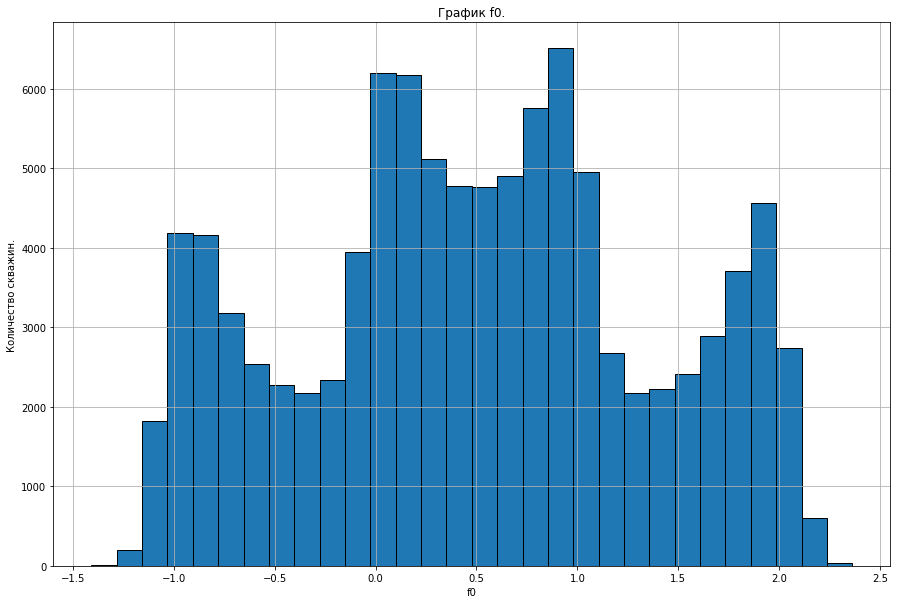

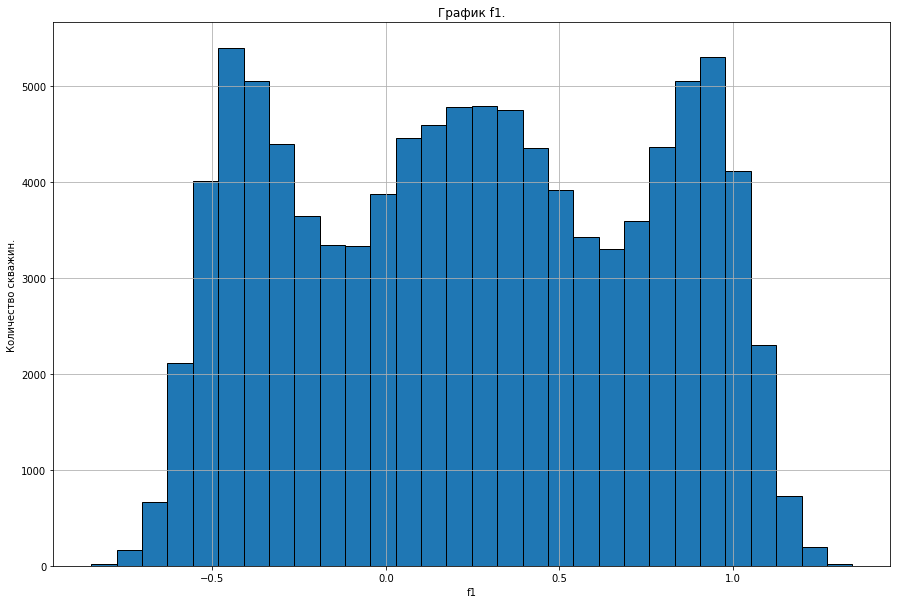

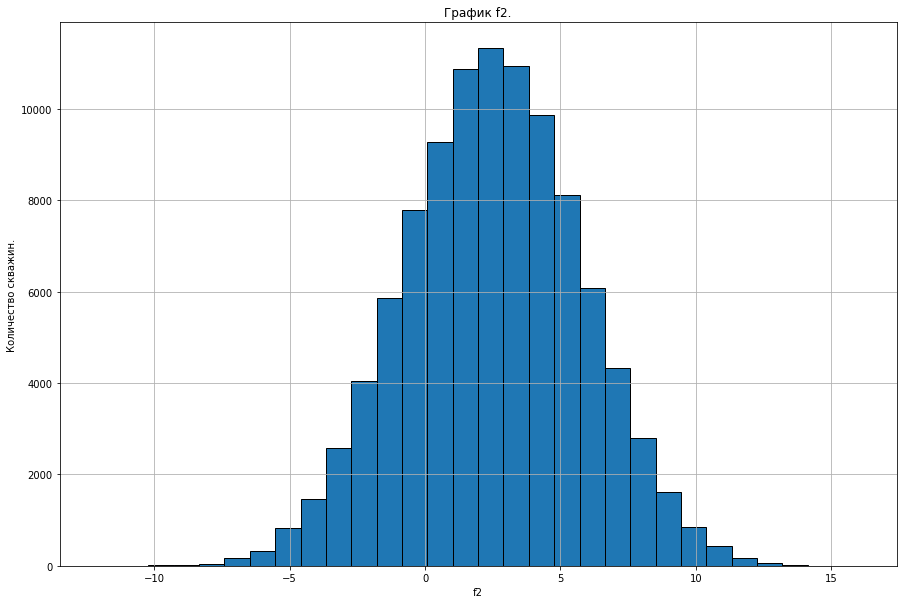

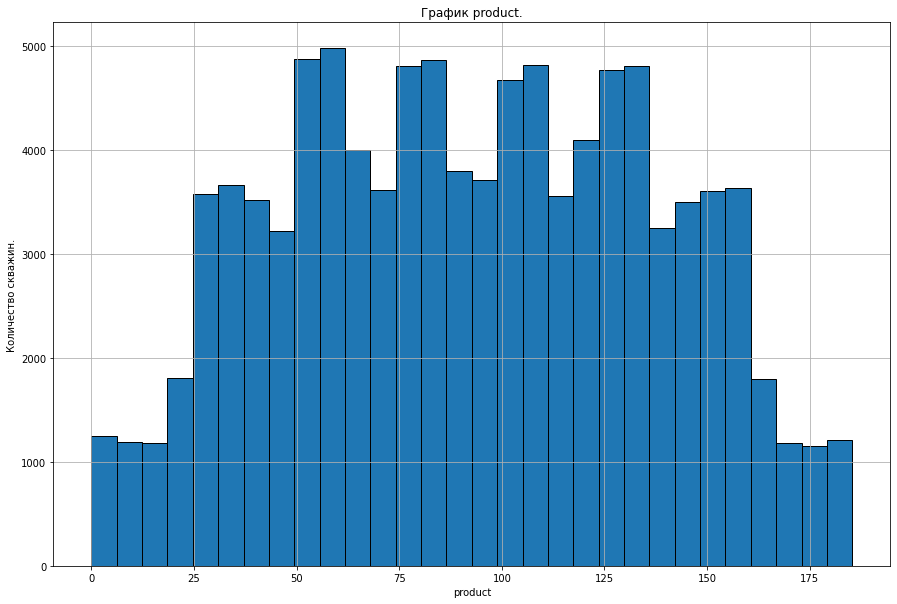

In [24]:
for i in features_for_plot:
    geo_data_0[i].plot.hist(bins=30, figsize=(15, 10), grid=True, ec='black');
    plt.xlabel(i)
    plt.ylabel('Количество скважин.')
    plt.title(f'График {i}.')
    plt.show()

По графикам выше видно, что распределнием, близким к нормальному, обладает только признак f2. Аномалий и выбросов нет.

Посмотрю корреляцию:

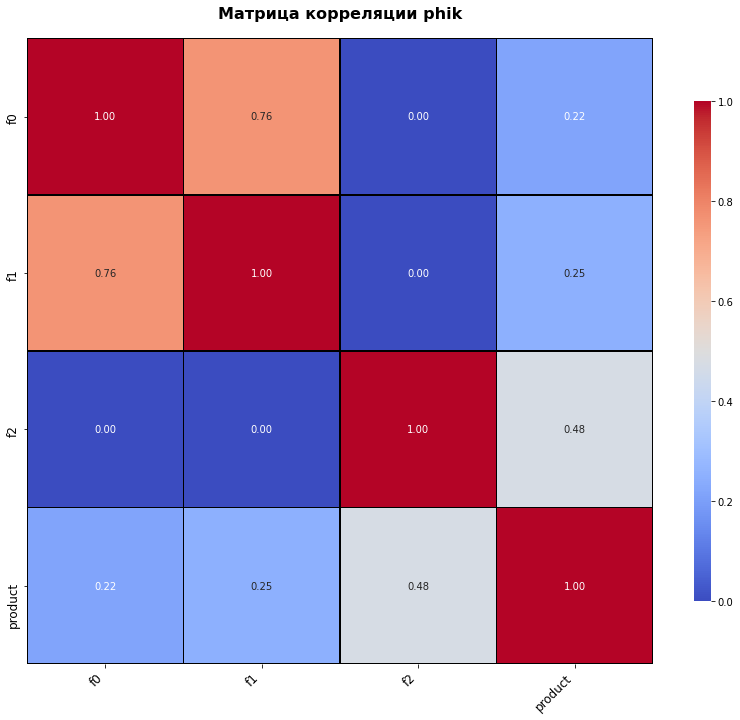

In [25]:
df_for_phik = geo_data_0.drop('id', axis=1).copy()

for col in df_for_phik.select_dtypes(include=['object']).columns:
    df_for_phik[col] = df_for_phik[col].astype('category')

numeric_cols = df_for_phik.select_dtypes(include=[np.number]).columns
phik_corr = df_for_phik.phik_matrix(interval_cols=numeric_cols)

plt.figure(figsize=(12, 10))
sns.heatmap(
    phik_corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=0, vmax=1,
    linewidths=0.5,
    linecolor='black',
    cbar_kws={"shrink": 0.8, "aspect": 30},
    square=True
)

plt.title("Матрица корреляции phik", fontsize=16, fontweight='bold', pad=20)
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


Критически высокой корреляции между признаками не обнаружено, мультиколлинеарность не выявлена.

***geo_data_1***

In [26]:
geo_data_1.describe()

,f0,f1,f2,product
count,99996.000000,99996.000000,99996.000000,99996.000000
mean,1.141209,-4.796608,2.494501,68.823916
std,8.965815,5.119906,1.703579,45.944663
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011475,57.085625
75%,8.620964,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


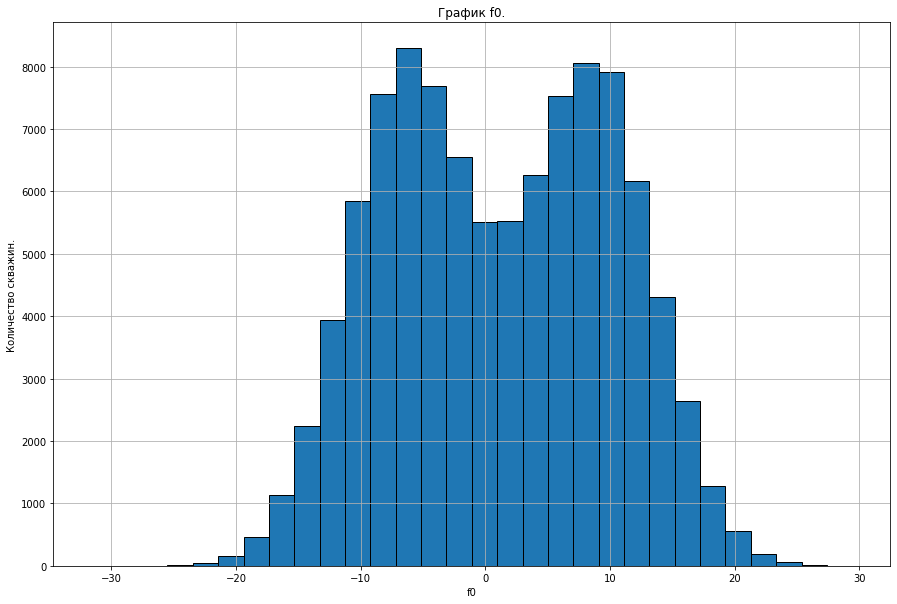

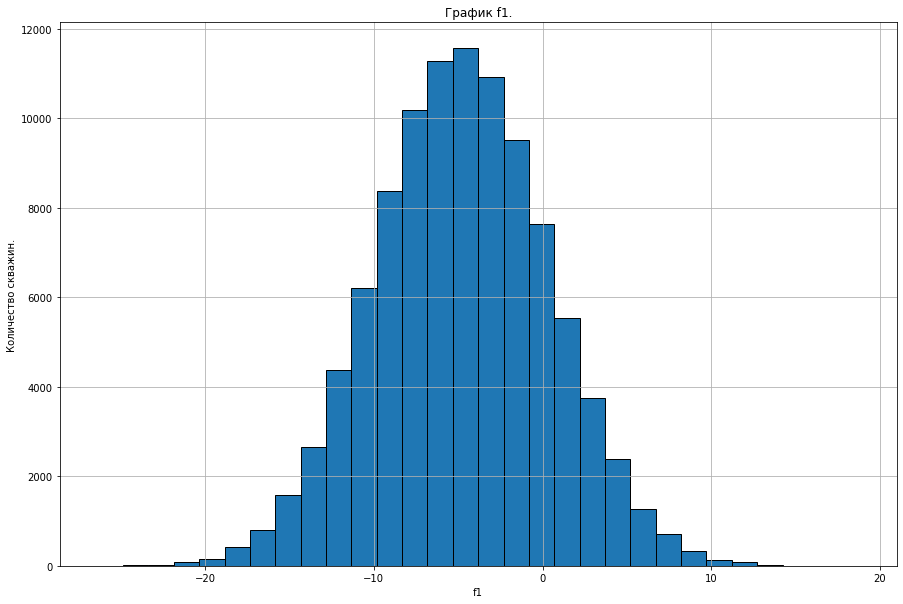

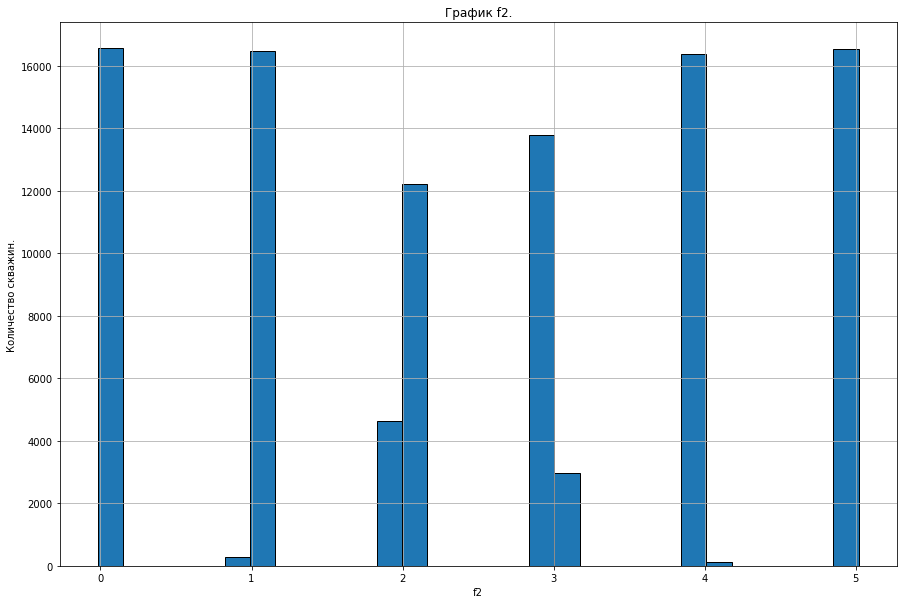

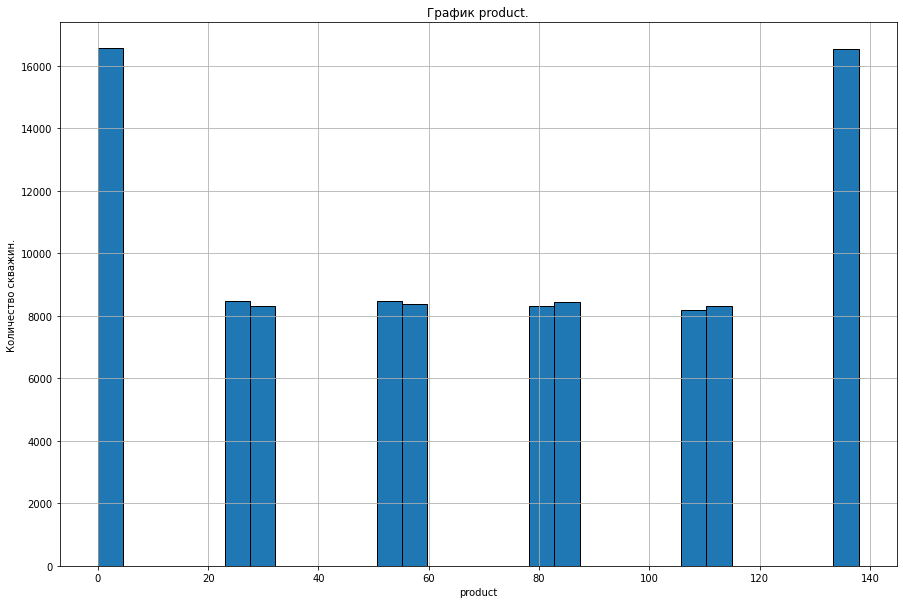

In [27]:
for i in features_for_plot:
    geo_data_1[i].plot.hist(bins=30, figsize=(15, 10), grid=True, ec='black');
    plt.xlabel(i)
    plt.ylabel('Количество скважин.')
    plt.title(f'График {i}.')
    plt.show()

На графиках признаков выше видно, что распределение около нормального присутствует только в признаке f1. Выбросов и аномальных значений нет.

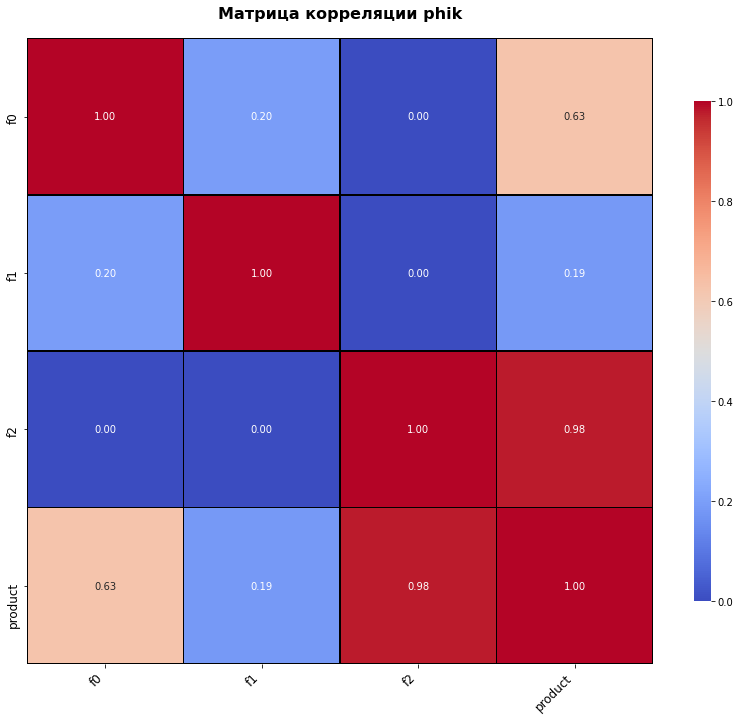

In [28]:
df_for_phik_1 = geo_data_1.drop('id', axis=1).copy()

for col in df_for_phik_1.select_dtypes(include=['object']).columns:
    df_for_phik_1[col] = df_for_phik_1[col].astype('category')

numeric_cols = df_for_phik_1.select_dtypes(include=[np.number]).columns
phik_corr = df_for_phik_1.phik_matrix(interval_cols=numeric_cols)

plt.figure(figsize=(12, 10))
sns.heatmap(
    phik_corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=0, vmax=1,
    linewidths=0.5,
    linecolor='black',
    cbar_kws={"shrink": 0.8, "aspect": 30},
    square=True
)

plt.title("Матрица корреляции phik", fontsize=16, fontweight='bold', pad=20)
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


Критически высокой корреляции между признаками не обнаружено, мультиколлинеарность не выявлена.

***geo_data_2***

In [29]:
geo_data_2.describe()

,f0,f1,f2,product
count,99996.000000,99996.000000,99996.000000,99996.000000
mean,0.002002,-0.002159,2.495084,94.998342
std,1.732052,1.730397,3.473482,44.749573
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162328,-1.174841,0.130269,59.450028
50%,0.009424,-0.009661,2.484236,94.925026
75%,1.158477,1.163523,4.858720,130.586815
max,7.238262,7.844801,16.739402,190.029838


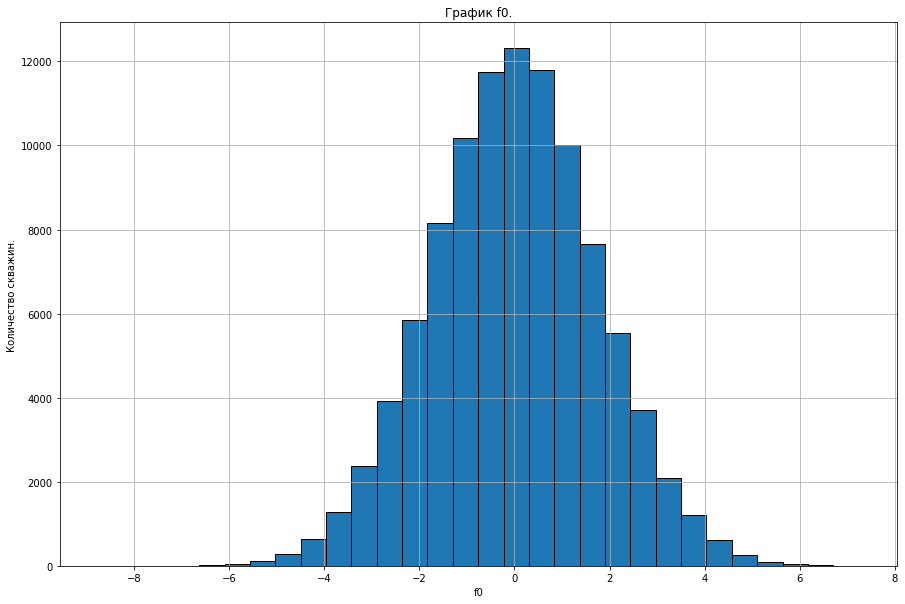

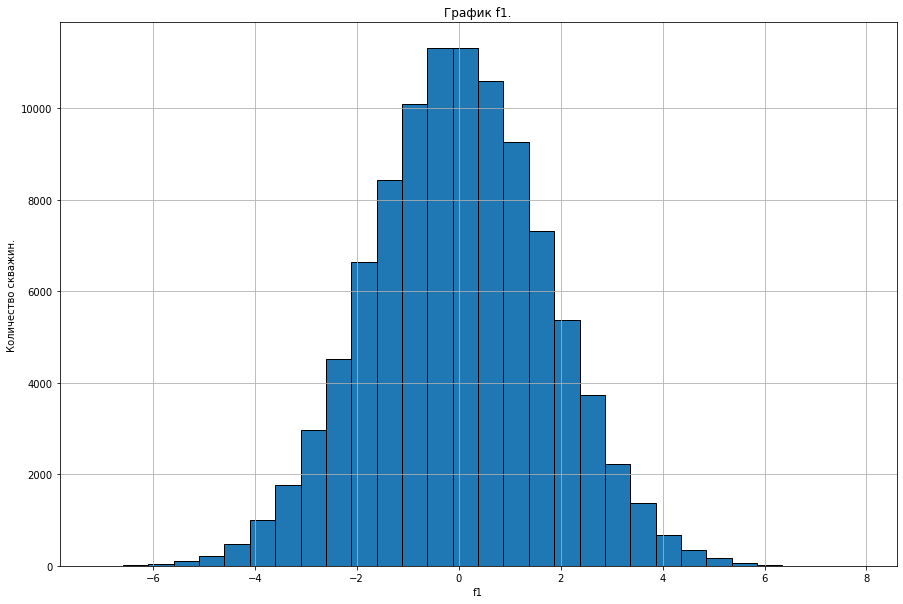

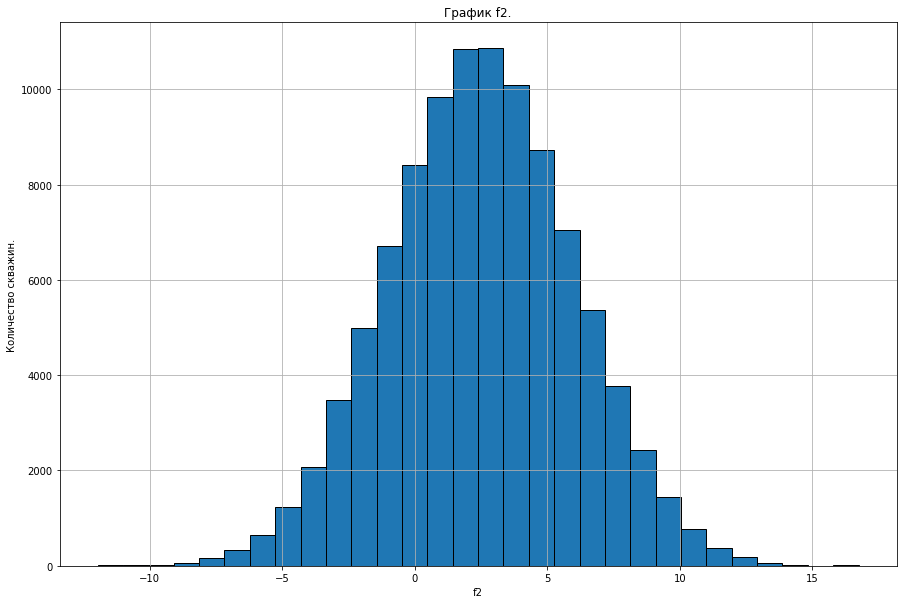

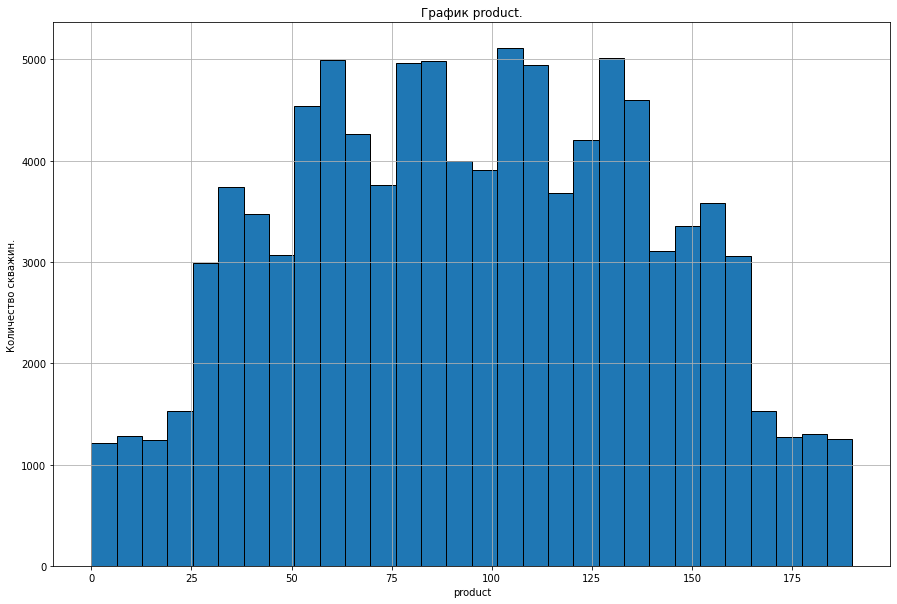

In [30]:
for i in features_for_plot:
    geo_data_2[i].plot.hist(bins=30, figsize=(15, 10), grid=True, ec='black');
    plt.xlabel(i)
    plt.ylabel('Количество скважин.')
    plt.title(f'График {i}.')
    plt.show()

На графиках этого датасета видно, что нормальное распределение присутствует в признаках f0, f1 и f2, аномальных значений или выбросов не найдено.

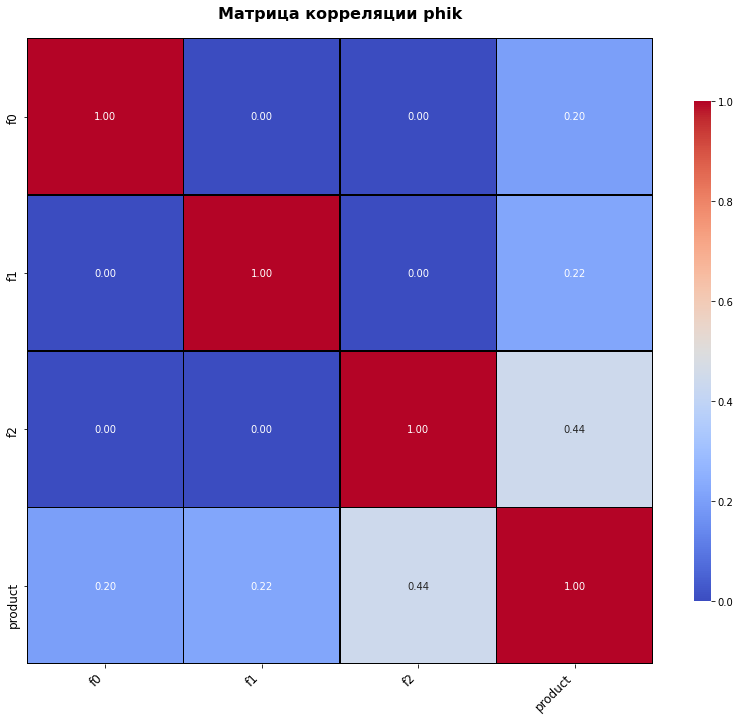

In [31]:
df_for_phik_2 = geo_data_2.drop('id', axis=1).copy()

for col in df_for_phik_2.select_dtypes(include=['object']).columns:
    df_for_phik_1[col] = df_for_phik_2[col].astype('category')

numeric_cols = df_for_phik_2.select_dtypes(include=[np.number]).columns
phik_corr = df_for_phik_2.phik_matrix(interval_cols=numeric_cols)

plt.figure(figsize=(12, 10))
sns.heatmap(
    phik_corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=0, vmax=1,
    linewidths=0.5,
    linecolor='black',
    cbar_kws={"shrink": 0.8, "aspect": 30},
    square=True
)

plt.title("Матрица корреляции phik", fontsize=16, fontweight='bold', pad=20)
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


Критически высокой корреляции между признаками не обнаружено, мультиколлинеарность не выявлена.

***Вывод***

***geo_data_0***

Распределнием, близким к нормальному, обладает только признак f2.

***geo_data_1***

Распределение около нормального присутствует только в признаке f1. Выбросов и аномальных значений нет.

***geo_data_2***

Нормальное распределение присутствует в признаках f0, f1 и f2.

Во всех трех датасетах аномальных значений и выбросов не обнаружено. Мультиколлинеарность не выявлена.

## Обучение и проверка модели

Обучу и проверю модель для каждого из трех регионов, а также сохраню предсказания:

In [32]:
RANDOM_STATE = 42

X_0 = geo_data_0.drop(columns=['id', 'product'], axis=1)
y_0 = geo_data_0['product']
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X_0, y_0, test_size=0.25, random_state=RANDOM_STATE) 

X_1 = geo_data_1.drop(columns=['id', 'product'], axis=1)
y_1 = geo_data_1['product']
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.25, random_state=RANDOM_STATE) 

X_2 = geo_data_2.drop(columns=['id', 'product'], axis=1)
y_2 = geo_data_2['product']
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.25, random_state=RANDOM_STATE) 

In [33]:
def linear_fit(X_train, X_test, y_train, y_test):
    model_lr = LinearRegression()
    model_lr.fit(X_train, y_train)
    y_pred = model_lr.predict(X_test)
    return y_pred

In [34]:
y_pred_0 = linear_fit(X_train_0, X_test_0, y_train_0, y_test_0)
y_pred_1 = linear_fit(X_train_1, X_test_1, y_train_1, y_test_1)
y_pred_2 = linear_fit(X_train_2, X_test_2, y_train_2, y_test_2)

In [35]:
print(f'RMSE geo_data_0: {mean_squared_error(y_test_0, y_pred_0) ** 0.5}')
print(f'RMSE geo_data_1: {mean_squared_error(y_test_1, y_pred_1) ** 0.5}')
print(f'RMSE geo_data_2: {mean_squared_error(y_test_2, y_pred_2) ** 0.5}')
print()
print(f'Средний запас предсказанного сырья geo_data_0: {y_pred_0.mean()}')
print(f'Средний запас предсказанного сырья geo_data_1: {y_pred_1.mean()}')
print(f'Средний запас предсказанного сырья geo_data_2: {y_pred_2.mean()}')

RMSE geo_data_0: 37.68508926201444
RMSE geo_data_1: 0.8928265978121422
RMSE geo_data_2: 40.080822438088305

Средний запас предсказанного сырья geo_data_0: 92.60984027552018
Средний запас предсказанного сырья geo_data_1: 68.57703454115173
Средний запас предсказанного сырья geo_data_2: 94.93478722287514


***Вывод***

Самое высокое среднее количество сырья находится в geo_data_2 и geo_data_0, но в этих регионах RMSE очень высокий, что говорит о высокой сложности прогноза сырья в этих регионах, в то время как в geo_data_1 очень низкий RMSE, но и средний запас сырья значительно ниже, чем в других.

## Подготовка к расчёту прибыли

Проведу подготовку к расчёту прибыли:

In [36]:
well_budget = 10_000_000_000
one_barrel_income_rub = 450
one_thousand_barrel_income_rub = 450_000
well_points = 500
well_ml_points = 200
budget_per_well = well_budget / well_ml_points
minimum_quantity_of_product = budget_per_well / one_thousand_barrel_income_rub
loss_probability = 0.025

Были созданы все нужные переменные, хранящие в себе бюджет, количество скважин, а также минимальное количество сырья для безубыточной разработки скважины, выведу это значение на экран и сравню со средними по всем регионам из прошлого пункта:

In [37]:
round(minimum_quantity_of_product, 5)

111.11111

***Вывод***

Значение для безубыточной разработки одной скважины - 111.11111 тыс баррелей, что является больше каждого среднего из всех регионов.

## Расчёт прибыли и рисков 

Напишу функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:

In [38]:
def best_wells(y_pred):
    profit = pd.Series(y_pred).sort_values(ascending=False)[:well_ml_points].sum() * one_thousand_barrel_income_rub - well_budget
    return profit

In [39]:
print(f'Прибыль от 200 лучших скважин в регионе geo_data_0 {best_wells(y_pred_0)}')
print(f'Прибыль от 200 лучших скважин в регионе geo_data_1 {best_wells(y_pred_1)}')
print(f'Прибыль от 200 лучших скважин в регионе geo_data_2 {best_wells(y_pred_2)}')

Прибыль от 200 лучших скважин в регионе geo_data_0 3953505894.021515
Прибыль от 200 лучших скважин в регионе geo_data_1 2483060328.4911556
Прибыль от 200 лучших скважин в регионе geo_data_2 3323508789.4212666


Исходя из предсказаний модели видно, что самым прибыльным регионом будет geo_data_0

Применю технику Bootstrap с 1000 выборок:

In [40]:
def bootstrap_profit(target, predictions, well_points, well_ml_points, one_thousand_barrel_income_rub, well_budget, loss_probability, n_samples=1000):
    state = np.random.RandomState(12345)
    values = []
    target = np.array(target)
    predictions = np.array(predictions)
    
    for _ in range(n_samples):
        sample_indices = state.choice(len(target), well_points, replace=True)
        sample_target = target[sample_indices]
        sample_predictions = predictions[sample_indices]
        sorted_indices = np.argsort(sample_predictions)[-well_ml_points:]
        selected_target = sample_target[sorted_indices]
        profit = (selected_target.sum() * one_thousand_barrel_income_rub) - well_budget
        values.append(profit)
    
    values_series = pd.Series(values)
    risk = (values_series < 0).mean() * 100
    product_values_mean = values_series.mean()
    lower_interval = values_series.quantile(loss_probability)
    upper_interval = values_series.quantile(1 - loss_probability)
    
    return product_values_mean, lower_interval, upper_interval, risk


In [41]:
values_mean_0, lower_0, upper_0, risk_0 = bootstrap_profit(y_test_0, y_pred_0, well_points, well_ml_points, one_thousand_barrel_income_rub, well_budget, loss_probability)
values_mean_1, lower_1, upper_1, risk_1 = bootstrap_profit(y_test_1, y_pred_1, well_points, well_ml_points, one_thousand_barrel_income_rub, well_budget, loss_probability)
values_mean_2, lower_2, upper_2, risk_2 = bootstrap_profit(y_test_2, y_pred_2, well_points, well_ml_points, one_thousand_barrel_income_rub, well_budget, loss_probability)

In [42]:
print(f'Регион geo_data_0: \nСреднее значение: {values_mean_0}, \nДоверительный интервал: {lower_0, upper_0}, \nРиск убытков: {risk_0}%\n')
print(f'Регион geo_data_1: \nСреднее значение: {values_mean_1}, \nДоверительный интервал: {lower_1, upper_1}, \nРиск убытков: {risk_1}%\n')
print(f'Регион geo_data_2: \nСреднее значение: {values_mean_2}, \nДоверительный интервал: {lower_2, upper_2}, \nРиск убытков: {risk_2}%\n')

Регион geo_data_0: 
Среднее значение: 417354353.4556372, 
Доверительный интервал: (-96261928.01843758, 933493095.4996519), 
Риск убытков: 5.8999999999999995%

Регион geo_data_1: 
Среднее значение: 432017870.03942716, 
Доверительный интервал: (51741836.3252449, 863042250.0217904), 
Риск убытков: 1.0%

Регион geo_data_2: 
Среднее значение: 356881964.6217666, 
Доверительный интервал: (-186256154.7554878, 892099105.6741308), 
Риск убытков: 8.9%



***Вывод***

Были проведены все необходимые расчеты, получены риски, средние значения, а также доверительные интервалы для каждого региона.

Резюмируя результаты, которые выведены выше можно заключить, что самое высокое среднее значение прибыли наблюдается в регионе geo_data_1, также здесь прослеживается минимальный уровень риска 1%, доверительный интервал довольно узкий, что говорит о надежности этого региона, все это в совокупности делает этот регион лучшим для разработки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.